# Import Libraries

In [30]:
import os
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, DataCollatorForLanguageModeling
from datasets import load_dataset #, load_metric
from peft import LoraConfig, get_peft_model, AutoPeftModelForCausalLM
import matplotlib.pyplot as plt
import numpy as np
# from sklearn.metrics import accuracy_score
import nltk
from nltk.tokenize import word_tokenize
import math
import sacrebleu 

### Check cuda available


In [31]:
check_cuda = torch.cuda.is_available()

device = torch.device('cuda' if check_cuda else 'cpu')
print(f"Cuda is available: {'True' if check_cuda else 'False'}\nUsing device: {device}")


Cuda is available: True
Using device: cuda


# Load Dataset

In [32]:
dataset = load_dataset('bitext/Bitext-customer-support-llm-chatbot-training-dataset')


In [33]:
print(dataset)
print(dataset.keys())
# print(f"\nflags: \n{set(dataset['train']['flags'])}")
# print(f"\ninstruction: \n{set(dataset['train']['instruction'])}")
print(f"\nintent: \n{set(dataset['train']['intent'])}")
print(f"\ncategory: \n{set(dataset['train']['category'])}")
# print(f"\nresponse: \n{set(dataset['train']['response'])}")



DatasetDict({
    train: Dataset({
        features: ['flags', 'instruction', 'category', 'intent', 'response'],
        num_rows: 26872
    })
})
dict_keys(['train'])

intent: 
{'cancel_order', 'create_account', 'change_shipping_address', 'recover_password', 'review', 'check_cancellation_fee', 'contact_human_agent', 'change_order', 'check_payment_methods', 'payment_issue', 'track_refund', 'switch_account', 'complaint', 'get_refund', 'edit_account', 'set_up_shipping_address', 'delivery_period', 'check_refund_policy', 'contact_customer_service', 'delivery_options', 'delete_account', 'newsletter_subscription', 'registration_problems', 'get_invoice', 'track_order', 'place_order', 'check_invoice'}

category: 
{'ORDER', 'CONTACT', 'REFUND', 'FEEDBACK', 'CANCEL', 'SHIPPING', 'INVOICE', 'DELIVERY', 'SUBSCRIPTION', 'PAYMENT', 'ACCOUNT'}


> [!NOTE]
> This dataset only contains a **train** split.
> Need to manually aplit it into training, validation, and test sets for model evaluation.



# Load the Tokenizer and Model
### Model Selection
Microsoft `DialogGTP-medium` is available in [huggingface](https://huggingface.co/microsoft/DialoGPT-medium) which fine-tuned on Reddit conversation data. 
- Model Size and Resource Balance: The `DialoGPT-medium model` provides a good balance between size and resource usage, making it suitable for handling conversational tasks efficiently without overloading system resources.
- Pre-trained Knowledge Base: Since it is pre-trained on a vast set of Reddit conversations, it’s equipped with a wide-ranging understanding of language patterns. This helps to interpret and generate coherent responses across diverse conversational topics.
- Optimized for Dialogue: Built specifically for conversation, DialoGPT-medium naturally excels at creating engaging responses. Its training makes it well-suited to jump into dialogue, making it a great choice for applications centered around conversation.


> [!NOTE]
> **pad_token**: This token is used to fill in extra space so that all sequences in a batch are the same length, making batch processing smoother and more efficient.
> **eos_token**: Short for "End of Sequence," this token marks where a sequence finishes, signaling to the model that it’s reached the end of the input or output.

In [34]:
# Load the Tokenizer and Model from Hugging Face
model_name = 'microsoft/DialoGPT-medium'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Set the pad_token to eos_token: 
# This helps avoid unwanted attention on padded positions because, during training, 
# the model learned to ignore anything after the eos_token.
if tokenizer.pad_token is None:
    print("Padding token")
    # tokenizer.add_special_tokens({'pad_token': '[PAD]'}) # For fine-tuning the model on tasks requiring distinct padding
    tokenizer.pad_token = tokenizer.eos_token

# Verify the pad_token:
# Padding is handled correctly to prevent unintended behavior during training and inference
print(f"Pad token: {tokenizer.pad_token}, ID: {tokenizer.pad_token_id}")
print(f"EOS token: {tokenizer.eos_token}, ID: {tokenizer.eos_token_id}")

# NOTE!
# Shows that both pad_token and eos_token are set correctly and have the same ID 50256
# If mismatch the assigned token, padding may not work correcly. It could lead issues in downstream tasks like training convergence or inference accuracy

# Load the pre-trained model
model = AutoModelForCausalLM.from_pretrained(model_name)

# Resize the embeddings to accommodate the new pad_token
model.resize_token_embeddings(len(tokenizer))

# move model to cuda in my case
model.to(device)

# Check the model architecture
print(model)


Padding token
Pad token: <|endoftext|>, ID: 50256
EOS token: <|endoftext|>, ID: 50256
GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_f

>[!NOTE]
> In GPT2LMHeadModel, c_attn and c_proj handle attention related transformations.
> It allows the model to learn new patterns in the attention mechanism to the data

# Data Preprocessing
Applied this function to format the conversation correctly. This function apply user instructions and assistnat response with proper tokenization. Each conversation is formatted w/ User and Assistant, separated by 'eos_token'.

Features are used: `instruction`, `response`, `category`, `intent`

Added multiple context to the model which can enhance its ability to generate accurate and relevant response.


In [35]:
def preprocess_function(examples):
    conversations = []
    # Features used: `instruction`, `response`, `category`, `intent`
    for instruction, response, category, intent in zip(examples['instruction'], examples['response'], examples['category'], examples['intent']):
        conversation = (
                        f"{tokenizer.eos_token}Category: {category}{tokenizer.eos_token}"
                        f"Intent: {intent}{tokenizer.eos_token}"
                        f"User(Customer): {instruction}{tokenizer.eos_token} "
                        f"Service Assistant: {response}{tokenizer.eos_token}"
                        # f"<BOS> Category: {category} </BOS>"
                        # f"<BOS> Intent: {intent} </BOS>"
                        # f"<BOS> User: {instruction} </BOS>"
                        # f"<BOS> Assistant: {response} </BOS>"
                        )
        conversations.append(conversation)

    # The tokenizer converts the conversations into input IDs, padding/truncating them to a maximum length of 512 tokens
    model_inputs = tokenizer(conversations, max_length=512, truncation=True, padding='max_length')
    
    # The model is trained to predict the next token in the sequence, so labels are set as a copy of the input IDs.
    model_inputs['labels'] = model_inputs['input_ids'].copy()
    return model_inputs


# Tokenize and Split the Dataset
- Applied 10% of the data for evaluation
- For efficiency, set to batched=True, which the preprocess_function receives a batch of examples at once.

In [36]:
# Tokenize & Split the Dataset
tokenized_dataset = dataset['train'].map(preprocess_function, batched=True, remove_columns=dataset['train'].column_names)

# Split the dataset into train and eval sets
split_datasets = tokenized_dataset.train_test_split(test_size=0.1)
train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']


# Create PEFT (LoRA) Configuration
- r (Rank): Determines the size of the low-rank matrices. A smaller r means fewer parameters.
- lora_alpha: Scaling factor to balance the contribution of the LoRA layers.
- target_modules: Specifies which layers in the model to apply LoRA. For DialoGPT (based on GPT-2), "c_attn" and "c_proj" are common targets (Check model archetecture above)
- lora_dropout: Dropout rate applied to the LoRA layers.
- bias: How biases are handled. Setted to "none" which the model’s biases remain untouched during training. 
- task_type: Defines the task type. For causal language modeling, use "CAUSAL_LM" (Task type: Causal Language Modeling).


In [37]:
# PEFT Config
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["c_attn", "c_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)


# Convert to PEFT Model and Check Trainable Params

In [38]:
# Convert to PEFT Model: Integrate the LoRA adapters into the pre-trained model using the configuration defined above.
peft_model = get_peft_model(model, lora_config)

peft_model.print_trainable_parameters()


/home/r0b0t4rl/anaconda3/envs/genAI/lib/python3.10/site-packages/peft/tuners/lora/layer.py:1150: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


trainable params: 2,162,688 || all params: 356,985,856 || trainable%: 0.6058


Only 0.6058% of the total model parameters are trainable

# Training Arguments
[Training Arguments](https://huggingface.co/docs/transformers/en/main_classes/trainer)
- output_dir: Directory to save model checkpoints

Defines the number of samples processed per device (GPU/CPU) during training and evaluation.
- per_device_train_batch_size: Batch size per device during training
- per_device_eval_batch_size: Batch size per device during evaluation

> [!TIP]
> Large Batch Size: It will lead faster training per epoch but require more epochs to converge.
> Smaller Batch Size: Take more time per epoch.
> Adjust Batch size based on GPU memory (nvidia-smi)
> In my case used smaller batch sizes with gradient accumulation
gradient_accumulation_steps=4,  # Number of update steps to accumulate before performing a backward/update pass

- num_train_epochs: Total number of training epochs. It specify the # of times the training algorithm will work through the entrie training dataset.

> [!TIP]
> For dataset size, smaller datasets may require more epochs to generalize well.
> Overfitting risk can be consider if too many epochs. Make sure monitor validation loss to determine when to stop.
> More epochs will take longer training times.

- learning_rate: Learning rate determines the step size at each iter while moving toward a min of loss func.
- fp16: Enable mixed precision training if GPU is available. It enables mixed precision training, which uses 16-bit floating point numers to reduce memory usage and speed up training.

- logging_steps: Log training metrics every 100 steps which determines how often in step training metrics are logged.

- eval_strategy: Evaluation strategy ('steps', 'epoch', 'no') specify when to run evaluation during training. Choosed 'step' in order to evaluate the model at regular intervals.
- eval_steps: Evaluate every # of steps.

- save_strategy: Save strategy for model checkpoints
- save_steps: Save checkpoint at # of steps

- report_to: Integrations for logging ('tensorboard', 'wandb', 'comet_ml'). 'None': Disable reporting to external services.

- load_best_model_at_end: Load the best model at the end of training
- metric_for_best_model: Metric to use to evaluate the best model. Commonly used loss.
- greater_is_better: For loss, lower is better. This indicates whether a higher metric value is better.
- logging_dir: Directory for storing logs for monitoring training.

In [39]:
training_args = TrainingArguments(
    output_dir='./customer_support_chatbot_peft2',
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    num_train_epochs=3,  # Reduced epochs to prevent overfitting
    learning_rate=3e-5,  # Slightly lower learning rate for better convergence
    fp16=torch.cuda.is_available(),
    logging_steps=100,
    eval_strategy='steps',
    eval_steps=500, 
    save_strategy='steps',
    save_steps=500,
    report_to='none',
    save_total_limit=2,  # Limit the total number of saved checkpoints
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    greater_is_better=False,
    logging_dir='./logs',
)


## Evaluate the Pre-Trained Model 
- Tokenizer

In [57]:
# Initialize a Trainer for the pre-trained (Foundation) Model
foundation_trainer = Trainer(
    model=foundation_model,
    args=training_args,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

# Evaluate the Foundation Model
eval_results_foundation = foundation_trainer.evaluate()
perplexity_foundation = math.exp(eval_results_foundation['eval_loss'])
print(f"PreTrained Model Perplexity: {perplexity_foundation}")


PreTrained Model Perplexity: 1901.6922739434885


# Create Data Collator
Define a [data collator](https://huggingface.co/docs/transformers/en/main_classes/data_collator) that will dynamically pad the inputs during training. A data collator is a function that is responsible for batch formation during training and evaluation. It processes individual dataset examples and combines them into a batch, applying necessary transformations such as padding and masking.

Specifically designed for language modeling tasks, this data collator handles the creation of batches for training language models.
- tokenizer: The tokenizer used to process the text data (It is necessary for padding and creating attention masks)
- mlm:Masked Language Modeling(mlm)
> [!TIP]
> mlm=True
> Used in models like BERT, where some tokens are masked, and the model is trained to predict them.
>
> mlm=False
> The model is trained to predict the next token in the sequence.
>
> mlm is not appropriate for causal language models like GPT-2 or DialoGPT. False setting aligns with the training objectives of causal language models.

In [41]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)  # Masked Language Modeling is disabled for causal language models

# Initialize the Trainer
Set up the Hugging Face Trainer with the PEFT model, training arguments, datasets, and data collator.

In [42]:
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
)


# Train the Model

In [43]:
trainer.train()


Step,Training Loss,Validation Loss
500,2.603700,2.259510
1000,2.055900,1.822832
1500,1.857600,1.647718
2000,1.728300,1.539233
2500,1.665900,1.460746
3000,1.600700,1.398751
3500,1.575300,1.367623
4000,1.533000,1.352919
4500,1.526900,1.346978


TrainOutput(global_step=4533, training_loss=1.9689473165414888, metrics={'train_runtime': 3267.0057, 'train_samples_per_second': 22.207, 'train_steps_per_second': 1.388, 'total_flos': 6.783866386985779e+16, 'train_loss': 1.9689473165414888, 'epoch': 2.9990076083360897})

## Evaluate the PEFT Model


In [59]:
# PEFT fine-tuned model
eval_results_peft = trainer.evaluate()
perplexity_peft = math.exp(eval_results_peft['eval_loss'])
print(f"Pre-trained Model Perplexity: {perplexity_foundation}")
print(f"PEFT Model Perplexity: {perplexity_peft}")


Pre-trained Model Perplexity: 1901.6922739434885
PEFT Model Perplexity: 3.845786708271636


[**Perplexity**](https://huggingface.co/docs/transformers/en/perplexity) measures how well a probability model predicts a sample. In the context of language models, compare to orifinal foundation model, PEFT model has lower perplexity which indicates better performance. The PEFT model is more confident and accurate in predictions.


## Compute BLEU Score for PEFT Model
generate_response_peft:
- model: The pre-trained language model.
- tokenizer: Tokenizer associated with the model for encoding and decoding text.
- instruction: The user input(prompt) to which the model should respond.
- category (optional): 'unknown'
- intent (optional): 'unknown'


In [71]:
# Compute BLEU Score for the PEFT Model using SacreBLEU
from sacrebleu.metrics import BLEU


# def generate_response_peft(model, tokenizer, instruction, category='unknown', intent='unknown'):
#     # Use eos_token as delimiters in the conversation format
#     conversation = (
#         f"<BOS> Category: {category} </BOS>"
#         f"<BOS> Intent: {intent} </BOS>"
#         f"<BOS> User: {instruction} </BOS>"
#         f"<BOS> Assistant:"
#     )
#     inputs = tokenizer(conversation, return_tensors='pt', padding=True).to(device) # Tokenize the conversation
#     with torch.no_grad():
#         outputs = model.generate(
#             input_ids=inputs["input_ids"],
#             attention_mask=inputs["attention_mask"],
#             max_new_tokens=50,
#             pad_token_id=tokenizer.pad_token_id,
#             eos_token_id=tokenizer.eos_token_id,
#             top_p=0.9,
#             temperature=0.7,
#             do_sample=True,
#         )
#     response = tokenizer.decode(outputs[0], skip_special_tokens=True)
#     assistant_reply = response.split('<BOS> Assistant:')[-1].strip()
#     return assistant_reply

def generate_response_peft(model, tokenizer, instruction, category='unknown', intent='unknown'):
    # Use eos_token as delimiters in the conversation format
    conversation = (
        f"{tokenizer.eos_token}Category: {category}{tokenizer.eos_token}"
        f"Intent: {intent}{tokenizer.eos_token}"
        f"User: {instruction}{tokenizer.eos_token}"
        f"Assistant:"
    )
    inputs = tokenizer(conversation, return_tensors='pt', padding=True).to(device) # Tokenize the conversation
    
    # Generate the response from the model w/out computing gradients
    with torch.no_grad():
        # Invokes the model's txt generation cability
        outputs = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_new_tokens=50, # Limit the response to 50 new tokens to avoid long outputs
            pad_token_id=tokenizer.pad_token_id,  # Padding handling. TokenID used for padding sequence.
            eos_token_id=tokenizer.eos_token_id,  # Set model stops generation at eos_token
            top_p=0.9,  # Nucleus sampling for diverse outputs. Promotes diversirty in the generated responses
            temperature=0.7, # Control the randomness of predictions by scaling the logits before applying softmax.
            do_sample=True,  # non-deterministic
        )
    
    # Decode the output and extract the assistant's reply. Convert the generated IDs back into human-readable string.
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    assistant_reply = response.split(f"Assistant:")[-1].strip()  # Extract response after 'Assistant:'
    return assistant_reply


# Computes the BLEU score btween the model's generated responses and the reference responses in the dataset.
def compute_bleu_sacrebleu(model, tokenizer, dataset):
    references = []
    predictions = []

    # BLEU score compute
    for example in dataset:
        input_ids = example['input_ids']
        labels = example['labels']
        
        # Decode the conversation
        conversation_text = tokenizer.decode(input_ids, skip_special_tokens=True)
        instruction_text = conversation_text.split('User:')[-1].split('Assistant:')[0].strip()
        
        # Decode the reference response
        label_text = tokenizer.decode(labels, skip_special_tokens=True)
        reference_response = label_text.split('Assistant:')[-1].strip()
        
        # Generate the model's response
        generated_response = generate_response_peft(model, tokenizer, instruction_text)
        
        # Collect reference and generated rsponse
        references.append(reference_response)
        predictions.append(generated_response)
    
    # Compute BLEU score using SacreBLEU
    bleu = BLEU()
    score = bleu.corpus_score(predictions, [references]) # Compute the BLEU score over the entire corpus (predictions and references)
    return score.score

# Calculate BLEU Score
bleu_score_peft = compute_bleu_sacrebleu(peft_model, tokenizer, eval_dataset)
print(f"PEFT Model SacreBLEU Score: {bleu_score_peft}")

PEFT Model SacreBLEU Score: 3.9768704821496477


> [!NOTE]
> **Higher BLEU Score:** Indicates closer similarity between the generated text and the reference text.
> **Lower BLEU Score:** Suggests greater divergence from the reference.




# Compare Original and PEFT Model

## Load the Original Foundation Model

In [72]:
# Load the Original Foundation Model
foundation_model = AutoModelForCausalLM.from_pretrained(model_name)
foundation_model.resize_token_embeddings(len(tokenizer))  # Ensure embeddings match tokenizer
foundation_model.to(device)
foundation_model.eval()


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=3072, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=1024)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=4096, nx=1024)
          (c_proj): Conv1D(nf=1024, nx=4096)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=50257, bias=False)
)

## Evaluate the Original Foundation Model

In [87]:
# Initialize a Trainer for the Foundation Model
foundation_trainer = Trainer(
    model=foundation_model,
    args=training_args,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
)

# Evaluate the Orifinal Foundation Model
eval_results_foundation = foundation_trainer.evaluate()
perplexity_foundation = math.exp(eval_results_foundation['eval_loss'])
print(f"OriginalFoundation Model Perplexity: {perplexity_foundation}")


OriginalFoundation Model Perplexity: 1901.6922739434885


## Compute BLEU Score for Foundation Model

In [88]:
# Define the Response Generation Function for the Foundation Model
# def generate_response_foundation(model, tokenizer, instruction):
#     # Use eos_token for consistency with the model's pretraining
#     conversation = (
#         f"<BOS> User: {instruction} </BOS>"
#         f"<BOS> Assistant:"
#     )
#     inputs = tokenizer(conversation, return_tensors='pt', padding=True).to(device)
#     with torch.no_grad():
#         outputs = model.generate(
#             input_ids=inputs["input_ids"],
#             attention_mask=inputs["attention_mask"],
#             max_new_tokens=50,
#             pad_token_id=tokenizer.pad_token_id,
#             eos_token_id=tokenizer.eos_token_id,
#             top_p=0.9,
#             temperature=0.7,
#             do_sample=True,
#         )
#     response = tokenizer.decode(outputs[0], skip_special_tokens=True) # Decode the generated output
#     assistant_reply = response.split('<BOS> Assistant:')[-1].strip()
#     return assistant_reply

def generate_response_foundation(model, tokenizer, instruction):
    conversation = (
        f"{tokenizer.eos_token}User: {instruction}{tokenizer.eos_token}"
        f"Assistant:"
    )
    inputs = tokenizer(conversation, return_tensors='pt', padding=True).to(device)
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_new_tokens=50,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
            top_p=0.9,
            temperature=0.7,
            do_sample=True,
        )
    
    response = tokenizer.decode(outputs[0], skip_special_tokens=True) # Decode the generated output
    
    assistant_reply = response.split("Assistant:")[-1].strip()
    return assistant_reply


def compute_bleu_sacrebleu_foundation(model, tokenizer, dataset):
    references = []
    predictions = []
    for example in dataset:
        input_ids = example['input_ids']
        labels = example['labels']
        
        conversation_text = tokenizer.decode(input_ids, skip_special_tokens=True)
        instruction_text = conversation_text.split('User:')[-1].split('Assistant:')[0].strip()
        label_text = tokenizer.decode(labels, skip_special_tokens=True)
        reference_response = label_text.split('Assistant:')[-1].strip()        
        generated_response = generate_response_foundation(model, tokenizer, instruction_text)

        references.append(reference_response)
        predictions.append(generated_response)
    
    bleu = BLEU()
    score = bleu.corpus_score(predictions, [references])
    return score.score

bleu_score_foundation = compute_bleu_sacrebleu_foundation(foundation_model, tokenizer, eval_dataset)
print(f"Orifinal Foundation Model SacreBLEU Score: {bleu_score_foundation}")


Orifinal Foundation Model SacreBLEU Score: 1.502236402963001e-12


## Compare the Results

In [89]:
# Compare the Results
print("\nComparison of Models:")
print(f"PEFT Model Perplexity: {perplexity_peft}")
print(f"OriginalFoundation Model Perplexity: {perplexity_foundation}")
print(f"PEFT Model SacreBLEU Score: {bleu_score_peft}")
print(f"Original Foundation Model SacreBLEU Score: {bleu_score_foundation}")



Comparison of Models:
PEFT Model Perplexity: 3.845786708271636
OriginalFoundation Model Perplexity: 1901.6922739434885
PEFT Model SacreBLEU Score: 3.9768704821496477
Original Foundation Model SacreBLEU Score: 1.502236402963001e-12


# Save the Fine-Tuned Model

In [90]:
peft_model.save_pretrained('./customer_support_chatbot_peft_model3')
tokenizer.save_pretrained('./customer_support_chatbot_peft_model3')

('./customer_support_chatbot_peft_model3/tokenizer_config.json',
 './customer_support_chatbot_peft_model3/special_tokens_map.json',
 './customer_support_chatbot_peft_model3/vocab.json',
 './customer_support_chatbot_peft_model3/merges.txt',
 './customer_support_chatbot_peft_model3/added_tokens.json',
 './customer_support_chatbot_peft_model3/tokenizer.json')

# Plot Training and Validation Loss

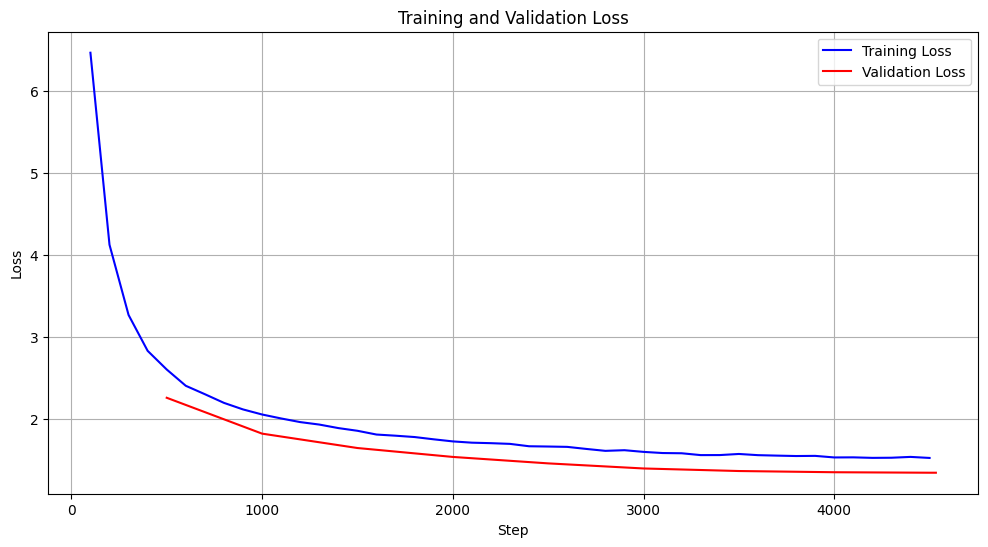

In [91]:
def plot_training_history(trainer, output_path='training_and_validation_loss_plot.png'):
    metrics = trainer.state.log_history
    train_steps = []
    train_loss = []
    eval_steps = []
    eval_loss = []

    for entry in metrics:
        if 'loss' in entry and 'learning_rate' in entry:
            train_steps.append(entry['step'])
            train_loss.append(entry['loss'])
        elif 'eval_loss' in entry:
            eval_steps.append(entry['step'])
            eval_loss.append(entry['eval_loss'])

    plt.figure(figsize=(12, 6))

    # Plot Training Loss
    if train_steps and train_loss:
        plt.plot(train_steps, train_loss, label='Training Loss', color='blue')

    # Plot Validation Loss
    if eval_steps and eval_loss:
        plt.plot(eval_steps, eval_loss, label='Validation Loss', color='red')

    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig(output_path)
    plt.show()

plot_training_history(trainer)


# Run with Saved Model
Inference and Testing with PEFT Model

In [92]:
tokenizer = AutoTokenizer.from_pretrained('./customer_support_chatbot_peft_model3')
peft_model = AutoPeftModelForCausalLM.from_pretrained('./customer_support_chatbot_peft_model3')

# Set the pad_token to eos_token
# Ensure pad_token is set
if tokenizer.pad_token is None:
    print("Padding token")
    # tokenizer.add_special_tokens({'pad_token': '[PAD]'}) # For fine-tuning the model on tasks requiring distinct padding
    tokenizer.pad_token = tokenizer.eos_token

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
peft_model.to(device)
peft_model.eval()


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): GPT2LMHeadModel(
      (transformer): GPT2Model(
        (wte): Embedding(50257, 1024)
        (wpe): Embedding(1024, 1024)
        (drop): Dropout(p=0.1, inplace=False)
        (h): ModuleList(
          (0-23): 24 x GPT2Block(
            (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (attn): GPT2SdpaAttention(
              (c_attn): lora.Linear(
                (base_layer): Conv1D(nf=3072, nx=1024)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1024, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=3072, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
  

# Test the Chatbot

In [93]:
test_instructions = [
    "Can you help me to order more of this product I bought previously, order number 123?",
    "How can I track my order which my order number is #1234",
    "I forgot my password, how can I reset it?",
    "How to return my product?",
]

print("===============================================")
print("Responses Using the PEFT Model:")
for instruction in test_instructions:
    response = generate_response_peft(peft_model, tokenizer, instruction)
    print(f"--\nUser: {instruction}")
    print(f"--\nAssistant: {response}\n")

print("===============================================")
print("Responses from the Orifinal Foundation Model:")
for instruction in test_instructions:
    response = generate_response_foundation(foundation_model, tokenizer, instruction)
    print(f"--\nUser: {instruction}")
    print(f"--\nAssistant: {response}\n")


Responses Using the PEFT Model:
--
User: Can you help me to order more of this product I bought previously, order number 123?
--
Assistant: I'm sorry to hear that you are having trouble with ordering your product. I'm here to assist you in finding the appropriate information to assist you in purchasing your product. Could you please provide me with the order number or any other relevant details? This

--
User: How can I track my order which my order number is #1234
--
Assistant: I understand your confusion and I'm here to assist you with tracking your order number. To track your order, you can log into your account on our website and navigate to the "Tracking" section. You should be able to find your order number

--
User: I forgot my password, how can I reset it?
--
Assistant: I've got it figured out. You can reset your password in our secure system by logging in to our website and clicking on the Reset Password button on the top right corner of the page. Once you've done that, you'll

# Interactive Widgets

In [94]:
import ipywidgets as widgets
from IPython.display import display

# Define options for intent and category
intent_options = [
    'unknown', 'create_account', 'registration_problems', 'review', 'place_order', 'set_up_shipping_address', 
    'track_order', 'change_order', 'recover_password', 'delivery_options', 'check_refund_policy', 
    'change_shipping_address', 'cancel_order', 'get_invoice', 'contact_customer_service', 
    'check_invoice', 'newsletter_subscription', 'switch_account', 'track_refund', 'delivery_period', 
    'check_cancellation_fee', 'edit_account', 'delete_account', 'get_refund', 'payment_issue', 
    'contact_human_agent', 'check_payment_methods', 'complaint'
]

category_options = [
    'unknown', 'PAYMENT', 'REFUND', 'INVOICE', 'ACCOUNT', 'SUBSCRIPTION', 'ORDER', 
    'DELIVERY', 'SHIPPING', 'CANCEL', 'CONTACT', 'FEEDBACK'
]

# Create dropdown widgets for intent and category
intent_dropdown = widgets.Dropdown(
    options=intent_options,
    description='Intent:',
    disabled=False,
)

category_dropdown = widgets.Dropdown(
    options=category_options,
    description='Category:',
    disabled=False,
)

# Create a text box for user instruction
instruction_text = widgets.Text(
    description='Instruction:',
    placeholder='Enter your instruction here',
    disabled=False
)

# Create an output widget to display the response
output = widgets.Output()

# Define the function to generate the response
def on_submit_clicked(b):
    # Clear previous output
    output.clear_output()
    
    # Retrieve the selected category, intent, and instruction text
    category = category_dropdown.value
    intent = intent_dropdown.value
    instruction = instruction_text.value
    
    # Generate the response
    response = generate_response_peft(peft_model, tokenizer, instruction, category=category, intent=intent)
    
    # Display the response
    with output:
        print(f"User: {instruction}")
        print(f"Assistant: {response}\n")

# Create a submit button
submit_button = widgets.Button(
    description="Submit",
    button_style="primary"
)
submit_button.on_click(on_submit_clicked)

# Display the widgets and output
display(intent_dropdown, category_dropdown, instruction_text, submit_button, output)

Dropdown(description='Intent:', options=('unknown', 'create_account', 'registration_problems', 'review', 'plac…

Dropdown(description='Category:', options=('unknown', 'PAYMENT', 'REFUND', 'INVOICE', 'ACCOUNT', 'SUBSCRIPTION…

Text(value='', description='Instruction:', placeholder='Enter your instruction here')

Button(button_style='primary', description='Submit', style=ButtonStyle())

Output()